---
## Initialize required packages 

In [1]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygeostat as gs

# For nearest neighbor queries
from scipy import spatial

# For train/test split and performance metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score, accuracy_score, recall_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Hyperopt for hyperparameter tuning
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope

warnings.filterwarnings('ignore') 


In [2]:
## Directories: Set the paths for the directories:

outdir = 'OK/'
exedir = 'exe/'



## Load dataset 

Load an example of exhaustive and sample files

In [3]:
griddef = gs.GridDef(grid_file='griddef.txt')
griddef

Pygeostat GridDef:
125 34407.5 15.0 
80 27407.5 15.0 
40 607.5 15.0

In [4]:
bhdata = gs.DataFile ('cudata.dat', griddef = griddef,
                       readfl=True)


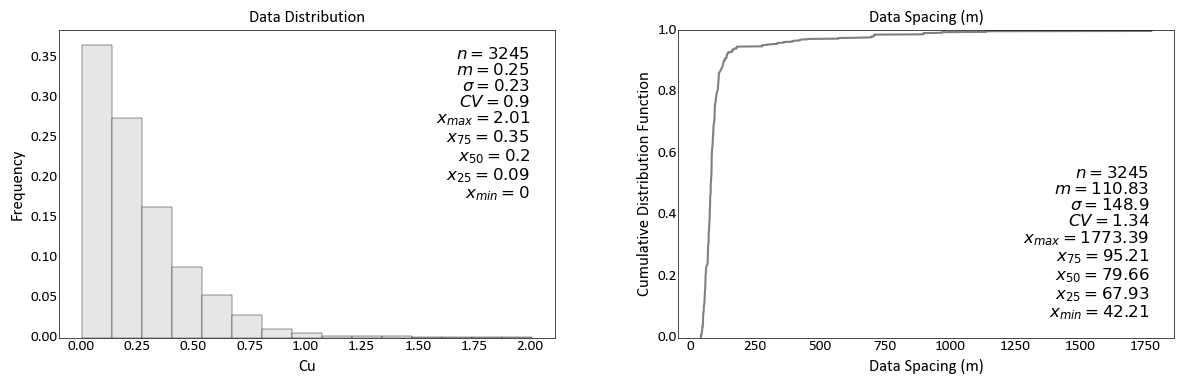

In [5]:
bhdata.spacing (100)
bhdata ['Data Spacing (m)'].describe ()

fig1, axes = plt.subplots (1, 2, figsize = (12, 4))

gs.histogram_plot(bhdata, var='Cu',  title = 'Data Distribution' ,ax=axes[0] )

gs.histogram_plot(bhdata, var='Data Spacing (m)',  icdf = True,  
                  title = 'Data Spacing (m)' ,ax=axes[1] )
fig1.tight_layout ()

plt.subplots_adjust (wspace = 0.25)

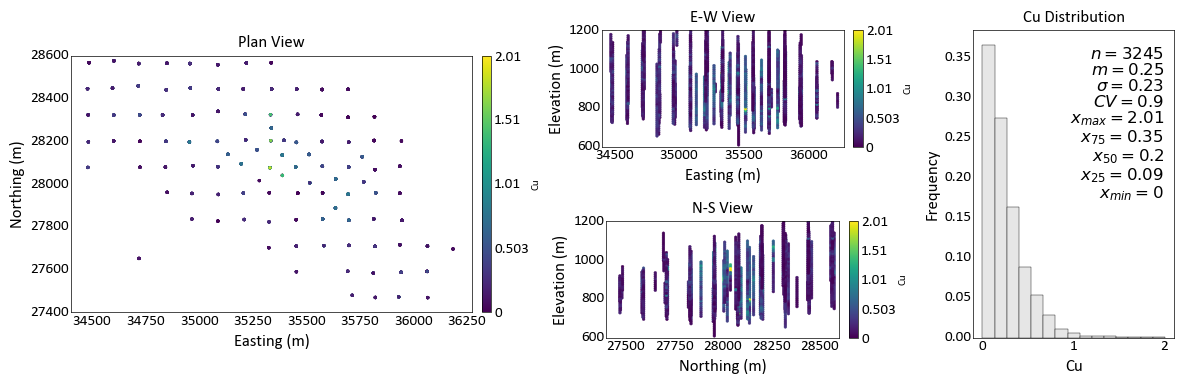

In [6]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig1 = plt.figure(figsize=(12, 4))
# Adjust the width_ratios to have three elements
gs2 = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[2, 2, 1])

# Define the axes using the custom gridspec layout
ax0 = fig1.add_subplot(gs2[:, 0])
ax1 = fig1.add_subplot(gs2[0, 1])
ax2 = fig1.add_subplot(gs2[1, 1])
ax3 = fig1.add_subplot(gs2[:, 2])

# Assuming gs is a custom object with methods location_plot and histogram_plot
gs.location_plot(bhdata, var='Cu', title = 'Plan View', cbar_label = 'Cu', griddef=griddef, 
                 s=4, orient='xy', ax=ax0, aspect = 1)
gs.location_plot(bhdata, var='Cu',  title = 'E-W View',cbar_label = 'Cu',griddef=griddef, 
                 s=4, orient='xz', ax=ax1, aspect = 1.5)
gs.location_plot(bhdata, var='Cu',  title = 'N-S View',cbar_label = 'Cu',griddef=griddef, 
                 s=4, orient='yz', ax=ax2, aspect = 1)
gs.histogram_plot(bhdata, var='Cu', title='Cu Distribution', ax=ax3)

# Adjust the layout spacing
plt.tight_layout()
plt.show()


Generate the prediction grid:
 

In [7]:
x,y,z = griddef.get_coordinates()
grid_coords= np.hstack((x.reshape(len(x),1),y.reshape((len(y)),1),z.reshape((len(z)),1)))


## Kfold

In [8]:
foldpar = """                  Parameters for KFOLD
                  ********************

START OF PARAMETERS:
{datafl}                     - file with data
0 1 2 3 4                    - columns for DH,X,Y,Z,VR
-1.0     1.0e21              - trimming limits
{outfl}                      - file for output
1                            - write Validation and Training files?
5                            - number of folds
1324978                      - random number seed
0.001  0.01  0.25   0.50     - weights: random, centroid, diff, same
"""
# kfold = gs.Program(program = exedir + 'kfold')

# kfold.run(parstr=foldpar.format(outfl = './Data/kfold.out', datafl = bhdata.flname), liveoutput = False)

In [9]:
kfold = gs.DataFile('./Data/kfold.out', cat='Fold (out of   5)', catdict = {1:1, 2:2, 3:3,4:4,5:5})

In [10]:
kfold

DataFile: ./Data/kfold.out
Attributes:
x: 'X',  y: 'Y',  z: 'Z',  cat: 'Fold (out of   5)',  
Variables:
Cu

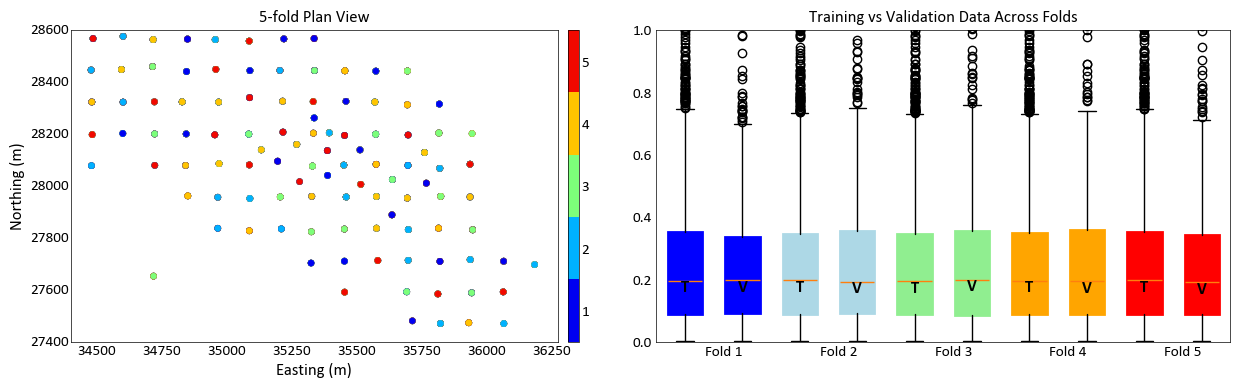

In [11]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
# Import gs if it's a custom module, otherwise specify the correct library
# import gs 

# Initialize lists to hold training and validation data for all folds
training_data = []
validation_data = []

# Iterate through each fold
for fold in range(1, 6):  # Adjusted to include fold 5
    # Read the training and validation data for the current fold
    Training = gs.DataFile('Training0{}.dat'.format(fold), x='X', y='Y', z='Z')
    Validation = gs.DataFile('Validation0{}.dat'.format(fold), x='X', y='Y', z='Z')

    # Extract the relevant columns for plotting, assuming 'Y' is the column
    training_values = Training['Cu']  # Replace 'Y' with the actual column name if different
    validation_values = Validation['Cu']  # Replace 'Y' with the actual column name if different

    # Append the data to the lists
    training_data.append(training_values)
    validation_data.append(validation_values)

# Create labels for the boxplot (optional, depending on usage)
labels = []
for fold in range(1, 6):
    labels.append(f'Training Fold {fold}')
    labels.append(f'Validation Fold {fold}')

fig1 = plt.figure(figsize=(13, 4))
# Adjust the width_ratios to have two elements
gs2 = gridspec.GridSpec(1, 2)

# Define the axes using the custom gridspec layout
ax0 = fig1.add_subplot(gs2[:, 0])
ax3 = fig1.add_subplot(gs2[:, 1])

# Ensure `gs` is properly imported and `griddef` is defined
kfold = gs.DataFile('./Data/kfold.out', cat='Fold (out of   5)', catdict={1: 1, 2: 2, 3: 3, 4: 4, 5: 5})
gs.location_plot(kfold, var='Fold (out of   5)', cmap='jet', griddef=griddef, title='5-fold Plan View',
                 s=20, orient='xy', ax=ax0)

colors = ['blue', 'lightblue', 'lightgreen', 'orange', 'red']  

# Plot all boxplots in the last subplot (ax3)
for i in range(5):
    bp = ax3.boxplot([training_data[i], validation_data[i]], positions=[i * 2 + 1, i * 2 + 2], 
                     widths=0.6, patch_artist=True)
    for j, box in enumerate(bp['boxes']):
        box.set(color=colors[i], linewidth=2)
        box.set(facecolor=colors[i])
        # Add bold "T" and "V" labels
        median = bp['medians'][j]
        median_y = median.get_ydata()[0]
        ax3.text(i * 2 + 1 + j, median_y - 0.05 * (median_y - median.get_ydata()[1]), 
                 'T' if j == 0 else 'V', ha='center', va='top', fontweight='bold')

ax3.set_title('Training vs Validation Data Across Folds', fontsize = 12)
ax3.set_xticks([i * 2 + 2 for i in range(5)])
ax3.set_xticklabels([f'Fold {i + 1}' for i in range(5)], ha='right')
ax3.set_ylim(0,1)

plt.tight_layout()
plt.show()


## DeepKriging

In [ ]:
import numpy as np
import pandas as pd
from scipy import spatial

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model Selection / Metrics
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# Hyperopt
from hyperopt import fmin, tpe, hp, Trials

# =============================================================================
# 1. Load / Normalize grid (full domain) coordinates
# =============================================================================
df1 = pd.DataFrame(grid_coords, columns=['X', 'Y', 'Z'])  # shape => (N, 3)
lon = df1['X'].values
lat = df1['Y'].values
elev = df1['Z'].values

normalized_lon = (lon - lon.min()) / (lon.max() - lon.min())
normalized_lat = (lat - lat.min()) / (lat.max() - lat.min())
normalized_elev = (elev - elev.min()) / (elev.max() - elev.min())

# Full domain coordinates as features
s_test = np.vstack((normalized_lon, normalized_lat, normalized_elev)).T

# =============================================================================
# 2. Define function for building Wendland basis
# =============================================================================
def wendland_basis_w3_s3(lon_norm, lat_norm, elev_norm):
    """
    Creates the Wendland kernel basis (phi) for the entire domain.
    Returns phi with zero columns removed.
    """
    N = len(lon_norm)

    # Example: using 5^3 = 125 knots
    num_basis = 5 ** 3
    knots_1dx = np.linspace(0, 1, int(np.cbrt(num_basis)))
    knots_1dy = np.linspace(0, 1, int(np.cbrt(num_basis)))
    knots_1dz = np.linspace(0, 1, int(np.cbrt(num_basis)))

    theta = 1 / np.cbrt(num_basis) * 2.5
    knots_x, knots_y, knots_z = np.meshgrid(knots_1dx, knots_1dy, knots_1dz)
    knots = np.column_stack((knots_x.flatten(), knots_y.flatten(), knots_z.flatten()))

    phi = np.zeros((N, num_basis), dtype=float)

    for k_i in range(num_basis):
        current_knot = knots[k_i, :]
        distances = np.linalg.norm(
            np.vstack((lon_norm, lat_norm, elev_norm)).T - current_knot,
            axis=1
        ) / theta

        # Wendland w3,s3
        mask = (distances >= 0) & (distances <= 1)
        phi[mask, k_i] = (
            (1 - distances[mask]) ** 6 *
            (35 * distances[mask]**2 + 18 * distances[mask] + 3) / 3
        )

    # Remove columns that might be all zeros
    col_sums = np.sum(phi != 0, axis=0)
    nonzero_cols = np.where(col_sums > 0)[0]
    phi_reduce = phi[:, nonzero_cols]

    return phi_reduce

# Build Wendland basis for entire domain
phi_reduce_full = wendland_basis_w3_s3(normalized_lon, normalized_lat, normalized_elev)

# =============================================================================
# 3. Outer loop: 5 folds
# =============================================================================
for fold in range(1, 6):
    print(f"\n========== OUTER FOLD {fold} ==========")

    # -------------------------------------------------------------------------
    # 3a. Load outer-train data
    # -------------------------------------------------------------------------
    Traindat = gs.DataFile(f'Training0{fold}.dat', x='X', y='Y', z='Z')
    df_train = Traindat.data

    # KD-Tree: find grid row indices nearest each training station
    tree = spatial.KDTree(df1[['X', 'Y', 'Z']].values)
    idx = tree.query(df_train[['X', 'Y', 'Z']].values)[1]

    # Group by neighbor index and compute mean 'Cu'
    df_train_neighbor = df_train.assign(neighbor=idx)
    df_pm25 = df_train_neighbor.groupby('neighbor')['Cu'].mean()

    # These grid rows correspond to the outer-train stations
    idx_new = df_pm25.index.values
    pm25 = df_pm25.values

    # Coordinates and Wendland basis at station locations
    s_obs = np.vstack((
        normalized_lon[idx_new],
        normalized_lat[idx_new],
        normalized_elev[idx_new]
    )).T
    phi_obs = phi_reduce_full[idx_new, :]

    # Build X, y for outer-train
    X_full = np.hstack((s_obs, phi_obs))
    y_full = pm25.reshape(-1, 1)

    # -------------------------------------------------------------------------
    # 3b. Define the model
    # -------------------------------------------------------------------------
    def create_model(hparams, input_dim):
        """
        Build a Keras model using hyperparameters.
        Three hidden layers, each with Dropout and fixed l1,l2 regularization.
        """
        l1_fixed = 1e-6
        l2_fixed = 1e-4
        neurons = int(hparams['neurons'])  # ensure int

        model = Sequential()

        # Hidden layer 1
        model.add(Dense(
            neurons,
            input_dim=input_dim,
            kernel_initializer='he_uniform',
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_fixed, l2=l2_fixed)
        ))
        model.add(Dropout(hparams['dropout']))

        # Hidden layer 2
        model.add(Dense(
            neurons,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_fixed, l2=l2_fixed)
        ))
        model.add(Dropout(hparams['dropout']))

        # Hidden layer 3
        model.add(Dense(
            neurons,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_fixed, l2=l2_fixed)
        ))
        model.add(Dropout(hparams['dropout']))

        # Output layer
        model.add(Dense(1, activation='linear'))

        optimizer = Adam(learning_rate=hparams['learning_rate'])
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    # -------------------------------------------------------------------------
    # 3c. Inner 5-fold CV for hyperparameter tuning via Hyperopt
    # -------------------------------------------------------------------------
    def hyperopt_objective(hparams):
        """
        Perform 5-fold CV on (X_full, y_full) and return average MSE.
        """
        epochs = int(hparams['epochs'])
        batch_size = int(hparams['batch_size'])

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        fold_mses = []

        for train_idx, val_idx in kf.split(X_full):
            X_tr, X_val = X_full[train_idx], X_full[val_idx]
            y_tr, y_val = y_full[train_idx], y_full[val_idx]

            model = create_model(hparams, input_dim=X_full.shape[1])
            model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)

            y_val_pred = model.predict(X_val)
            fold_mses.append(mean_squared_error(y_val, y_val_pred))

        return np.mean(fold_mses)  # hyperopt tries to minimize this

    # Define Hyperparameter search space (similar to original approach)
    search_space = {
        'neurons':       hp.quniform('neurons', 400, 800, 200),
        'dropout':       hp.uniform('dropout', 0.2, 0.5),
        'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
        'epochs':        hp.quniform('epochs', 200, 400, 100),
        'batch_size':    hp.quniform('batch_size', 16, 64, 16),
    }

    # Optimize hyperparams
    trials = Trials()
    best = fmin(
        fn=hyperopt_objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=20,
        trials=trials,
        rstate=np.random.default_rng(42)
    )

    # Convert to int
    best['neurons']    = int(best['neurons'])
    best['epochs']     = int(best['epochs'])
    best['batch_size'] = int(best['batch_size'])

    print("Best hyperparameters from inner CV:")
    print(best)

    # -------------------------------------------------------------------------
    # 4. Retrain final model on the FULL outer-train data
    # -------------------------------------------------------------------------
    final_model = create_model(best, input_dim=X_full.shape[1])
    final_model.fit(
        X_full, y_full,
        epochs=best['epochs'],
        batch_size=best['batch_size'],
        verbose=0
    )

    # -------------------------------------------------------------------------
    # 5. Predict on the entire domain
    # -------------------------------------------------------------------------
    # Build full-domain features: concatenation of s_test + Wendland basis
    X_RBF_pred = np.hstack((s_test, phi_reduce_full))
    PM25_pred = final_model.predict(X_RBF_pred)

    # Clip negatives (optional)
    PM25_pred[PM25_pred < 0] = 0

    # Save domain predictions
    outfile = f'DeepKriging_{fold}.out'
    gs.write_gslib(pd.DataFrame(PM25_pred), outfile)
    print(f"Domain predictions saved: {outfile}")

    # -------------------------------------------------------------------------
    # 6. Evaluate on the external/validation set
    # -------------------------------------------------------------------------
    testfile = gs.DataFile(flname=f'Validation0{fold}.dat', griddef=griddef, readfl=True)
    DeepKriging = gs.DataFile(f'DeepKriging_{fold}.out', griddef=griddef)

    idx, ingrid = griddef.get_index(
        x=testfile.data['X'],
        y=testfile.data['Y'],
        z=testfile.data['Z']
    )

    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx >= 0]

    # Suppose 'Cu' is the true column, '0' is the predicted column
    r2_value = r2_score(
        testfile['Cu'],
        DeepKriging.data['0'][idx].values
    )
    print(f"R^2 on Validation fold {fold}: {r2_value:.4f}")


## Ordinary Kriging

In [13]:
f = open('varmodel.var', "r")
varg = f.readlines()
f.close()
varg = ''.join(varg)

In [14]:
print(varg)

  2       0.00000    -nst, nugget effect
  1       0.35000     100.00000     -10.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
         45.00000         45.00000         30.00000    -a_hmax, a_hmin, a_vert (ranges)
  1       0.65000     100.00000     -10.00000       0.00000    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        380.00000        340.00000        340.00000    -a_hmax, a_hmin, a_vert (ranges)



In [15]:
kt3dnpar = """                 Parameters for KT3DN
                 ********************
START OF PARAMETERS:
{datafl}                         -file with data
0  {xyzcol} {varcol}  0          -columns for DH,X,Y,Z,var,sec var
-998.0    1.0e21                 -trimming limits
0                                -option: 0=grid, 1=cross, 2=jackknife
xvk.dat                          -file with jackknife data
1   2   0    3    0              -columns for X,Y,Z,vr and sec var
kt3dn_dataspacing.out            -data spacing analysis output file (see note)
0    15.0                        -number to search (0 for no dataspacing analysis, rec. 10 or 20) and composite length
0    100   0                     -debugging level: 0,3,5,10; max data for GSKV;output total weight of each data?(0=no,1=yes)
kt3dn.dbg-nkt3dn.sum             -file for debugging output (see note)
{outfl}                          -file for kriged output (see GSB note)
{griddef}
5    5      5                    -x,y and z block discretization
8    48    12    1              -min, max data for kriging,upper max for ASO,ASO incr
90      0                        -max per octant, max per drillhole (0-> not used)
500.0  500.0  500.0              -maximum search radii
100.0   0   0.0                  -angles for search ellipsoid
1                                -0=SK,1=OK,2=LVM(resid),3=LVM((1-w)*m(u))),4=colo,5=exdrift,6=ICCK
0.180 0.6  0.8                   -mean (if 0,4,5,6), corr. (if 4 or 6), var. reduction factor (if 4)
0 0 0 0 0 0 0 0 0                -drift: x,y,z,xx,yy,zz,xy,xz,zy
0                                -0, variable; 1, estimate trend
extdrift.out                     -gridded file with drift/mean
4                                -column number in gridded file
key_out.out                      -gridded file with keyout (see note)
0    1                           -column (0 if no keyout) and value to keep
2    0.01                        -  nst, nugget effect
1    0.35   100.0   -10.0   0.0  - it,cc,ang1,ang2,ang3
       45    45    30            - a_hmax, a_hmin, a_vert
1    0.64   100.0   -10.0   0.0  - it,cc,ang1,ang2,ang3
       380    340    340         - a_hmax, a_hmin, a_vert
"""
# kt3dn = gs.Program(program = exedir + '/kt3dn')

# for fold in range(1,6):
#     Traindat = gs.DataFile(flname='Training0{}.dat'.format(fold), griddef = griddef,
#                        readfl=True)  
    
#     kt3dn.run(parstr=kt3dnpar.format(datafl = Traindat.flname,
#                                                 xyzcol = Traindat.gscol(Traindat.xyz),
#                                                 varcol = Traindat.gscol('Cu'),                              
#                                                 griddef = griddef,
#                                                 outfl = 'OK_{}.out'.format(fold)))          
    


## DeepKriging + IDW

In [16]:
import itertools

In [17]:
parstr = """                  Parameters for LDWgenerator
                  **********************

START OF PARAMETERS:
{datafl}                 - file with data
1  2  3  4  0            - columns for X, Y, Z coordinates variable and weight
-1.0     1.0e21          - trimming limits
1                        - including declustering weights by? 0 = scaling, 1=self calibration 
1                          Parameter calibration mode? no = 0, yes =1
1                        - anchor points in file =0, in grid =1
{grid}
aploc.clp                - file with anchor points locations
1  2  3                  - columns for X, Y, Z anchor point coordinates
1  {p}  {c}              - Weigting function (1=ID, 2=GK)  and parameters
0                        - dynamic bandwidth? 0=no, 1=yes
 100.0  0.0  0.0           - Anisotropic search angles
 500.0  500.0 500.0      - Anisotropic search radius
{weightsfl}              - file for weights output
{debuggingfl}            - file for debugging
{sumfl}                  - file for summary
"""


# LDWgenerator = gs.Program(program='./exe/LDWgenerator', getpar=True)

# for fold in range(1,6):
#     Traindat = gs.DataFile(flname='Training0{}.dat'.format(fold), griddef = griddef,
#                        readfl=True)  
    

#     LDWgenerator.run(parstr=parstr.format(datafl=Traindat.flname,
#                                           grid=griddef,
#                                           p=4,
#                                           c=0,
#                                           weightsfl='./IDW/Weights_{}.out'.format(fold),
#                                           debuggingfl='./IDW/Debug_{}.out'.format(fold),
#                                           sumfl='./IDW/Sum_{}.out'.format(fold)), liveoutput = False)




## Combination

In [27]:
for fold in range(1,6):
    

    
    deepkriging = gs.DataFile('DeepKriging_{}.out'.format(fold),griddef=griddef)
    
    moment = gs.DataFile('./IDW/Debug_{}.out'.format(fold), x = 'APX', y = 'APY')
    
    moment.data['Variance'] = moment.data['Local std.dev.']**2
    moment.data['Scaled_Variance'] = (moment.data['Variance'] -moment.data['Variance'].min())/(moment.data['Variance'].max()- moment.data['Variance'].min())


    weight =  moment['Scaled_Variance']**0.25

    cond_DK = deepkriging['0'] * np.array(weight) + moment['Local Mean'] * (1-np.array(weight)) 

    gs.write_gslib(pd.DataFrame(cond_DK), './IDW/Weighted_DK_{}.out'.format(fold))  



## Comparision

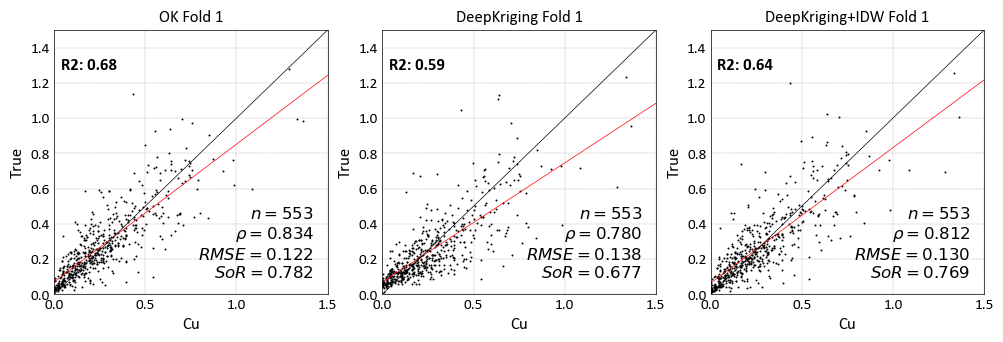

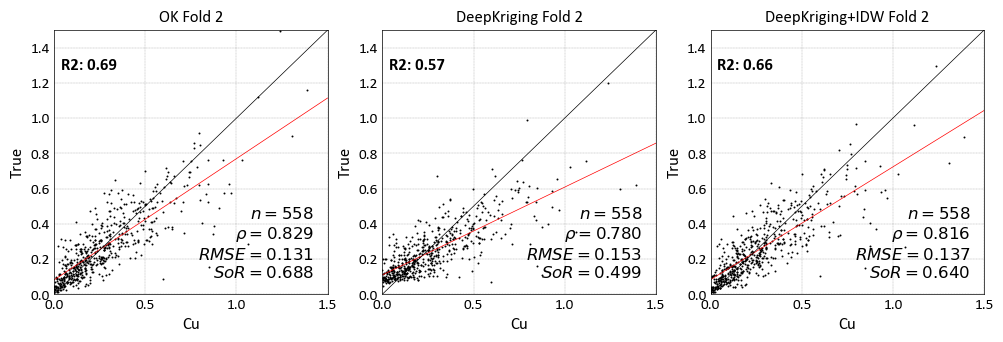

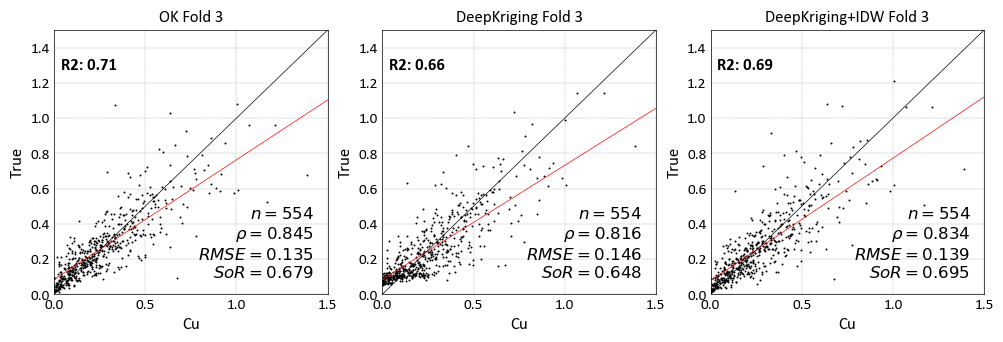

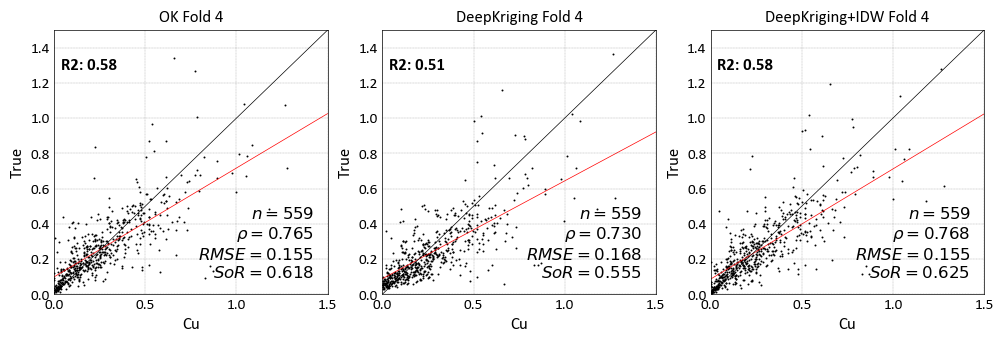

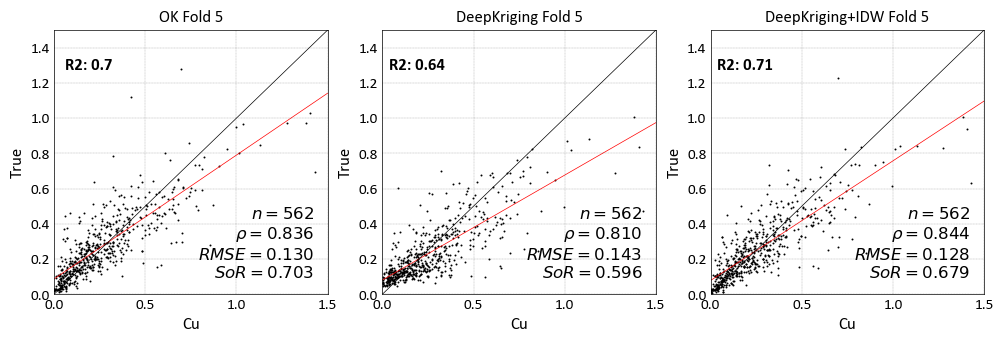

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd

OK_R2 = 0
DeepKriging_R2 = 0
Cond_DK_R2 = 0
OK_Ensemble = 0
DeepKriging_Ensemble = 0
Cond_DK_Ensemble = 0

for fold in range(1, 6):
    # Read the validation file
    testfile = gs.DataFile(flname='Validation0{}.dat'.format(fold),
                           griddef=griddef, readfl=True)

    # Read the kriging outputs
    OK = gs.DataFile('OK_{}.out'.format(fold), griddef=griddef)
    # Ensure no negative estimates
    OK.data.loc[OK.data['Estimate'] < 0, 'Estimate'] = 0

    DeepKriging = gs.DataFile('DeepKriging_{}.out'.format(fold), griddef=griddef)
    Cond_DK = gs.DataFile('./IDW/Weighted_DK_{}.out'.format(fold), griddef=griddef)

    # Get indices for testfile data points
    idx, ingrid = griddef.get_index(x=testfile.data['X'],
                                    y=testfile.data['Y'],
                                    z=testfile.data['Z'])
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx >= 0]

    # Create subplots
    f, axes = plt.subplots(1, 3, figsize=(12, 3.5))

    # OK plot
    gs.validation_plot(
        testfile['Cu'], OK.data['Estimate'][idx].values,
        grid=True, stat_blk='minimal', ms=2,
        title='OK Fold {}'.format(fold), figsize=(4, 4),
        ax=axes[0], vlim=(0, 1.5)
    )
    axes[0].text(
        0.19, 1.3,
        'R2: {}'.format(round(r2_score(testfile['Cu'], OK.data['Estimate'][idx].values), 2)),
        horizontalalignment='center', verticalalignment='center',
        fontsize=12, fontweight='bold'
    )

    # DeepKriging plot
    gs.validation_plot(
        testfile['Cu'], DeepKriging.data['0'][idx].values,
        grid=True, stat_blk='minimal', ms=2,
        title='DeepKriging Fold {}'.format(fold), figsize=(4, 4),
        ax=axes[1], vlim=(0, 1.5)
    )
    axes[1].text(
        0.19, 1.3,
        'R2: {}'.format(round(r2_score(testfile['Cu'], DeepKriging.data['0'][idx].values), 2)),
        horizontalalignment='center', verticalalignment='center',
        fontsize=12, fontweight='bold'
    )

    # Cond_DK plot
    gs.validation_plot(
        testfile['Cu'], Cond_DK.data['0'][idx].values,
        grid=True, stat_blk='minimal', ms=2,
        title='DeepKriging+IDW Fold {}'.format(fold), figsize=(4, 4),
        ax=axes[2], vlim=(0, 1.5)
    )
    axes[2].text(
        0.19, 1.3,
        'R2: {}'.format(round(r2_score(testfile['Cu'], Cond_DK.data['0'][idx].values), 2)),
        horizontalalignment='center', verticalalignment='center',
        fontsize=12, fontweight='bold'
    )

    # Attempt to resolve aspect ratio warnings by resetting aspect
    for a in axes:
        a.set_aspect('auto')  # You may experiment with 'equal', 'datalim', etc.

    # Update cumulative R2 scores
    OK_R2 += r2_score(testfile['Cu'], OK.data['Estimate'][idx].values)
    DeepKriging_R2 += r2_score(testfile['Cu'], DeepKriging.data['0'][idx].values)
    Cond_DK_R2 += r2_score(testfile['Cu'], Cond_DK.data['0'][idx].values)

    # Update ensemble predictions
    OK_Ensemble += OK.data['Estimate'].values.reshape(-1, 1)
    DeepKriging_Ensemble += DeepKriging.data['0'].values.reshape(-1, 1)
    Cond_DK_Ensemble += Cond_DK.data['0'].values.reshape(-1, 1)

# Compute average performances
OK_Performance = round(OK_R2 / 5, 3)
DeepKriging_Performance = round(DeepKriging_R2 / 5, 3)
Cond_DK_Performance = round(Cond_DK_R2 / 5, 3)

# Compute average ensemble predictions
OK_Avg = OK_Ensemble / 5
DeepKriging_Avg = DeepKriging_Ensemble / 5
Cond_DK_Avg = Cond_DK_Ensemble / 5

# Write outputs
gs.write_gslib(pd.DataFrame(OK_Avg), 'OK_Average.out')
gs.write_gslib(pd.DataFrame(DeepKriging_Avg), 'DeepKriging_Average.out')
gs.write_gslib(pd.DataFrame(Cond_DK_Avg), 'Cond_DK_Average.out')


In [29]:
pd.DataFrame(DeepKriging_Avg).describe()

,0
count,400000.000000
mean,0.147622
std,0.126245
min,0.020144
25%,0.077965
50%,0.100366
75%,0.166522
max,1.392768


In [30]:
print(round(OK_Performance,2))
print(round(DeepKriging_Performance,2))
print(round(Cond_DK_Performance,2))

0.67
0.6
0.66


In [31]:
from sklearn.metrics import mean_squared_error

# Initialize RMSE values
OK_RMSE = 0
DeepKriging_RMSE = 0
Cond_DK_RMSE = 0


for fold in range(1, 6):
    testfile = gs.DataFile(flname='Validation0{}.dat'.format(fold), griddef=griddef, readfl=True)
    
    OK = gs.DataFile('OK_{}.out'.format(fold), griddef=griddef)
    OK.data['Estimate'][OK.data['Estimate'] < 0] = 0
    
    DeepKriging = gs.DataFile('DeepKriging_{}.out'.format(fold), griddef=griddef)   
    Cond_DK = gs.DataFile('./IDW/Weighted_DK_{}.out'.format(fold), griddef=griddef)
    
    idx, ingrid = griddef.get_index(x=testfile.data['X'], y=testfile.data['Y'], z=testfile.data['Z'])
    testfile.data = testfile.data[idx >= 0]
    idx = idx[idx >= 0]    
    
    
    OK_rmse = np.sqrt(mean_squared_error(testfile['Cu'], OK.data['Estimate'][idx].values))
    DeepKriging_rmse = np.sqrt(mean_squared_error(testfile['Cu'], DeepKriging.data['0'][idx].values))
    Cond_DK_rmse = np.sqrt(mean_squared_error(testfile['Cu'], Cond_DK.data['0'][idx].values))
    
    
    OK_RMSE += OK_rmse
    DeepKriging_RMSE += DeepKriging_rmse   
    Cond_DK_RMSE += Cond_DK_rmse


OK_Performance = round(OK_RMSE/5, 3)
DeepKriging_Performance = round(DeepKriging_RMSE/5, 3)    
Cond_DK_Performance = round(Cond_DK_RMSE/5, 3)  
    


print(round(OK_Performance,3))
print(round(DeepKriging_Performance,3))
print(round(Cond_DK_Performance,3))


0.135
0.15
0.138


## Plotting

In [8]:
ok_results = gs.DataFile('OK_Average.out')
deepkriging_results = gs.DataFile('DeepKriging_Average.out')
Cond_DK_results = gs.DataFile('Cond_DK_Average.out')


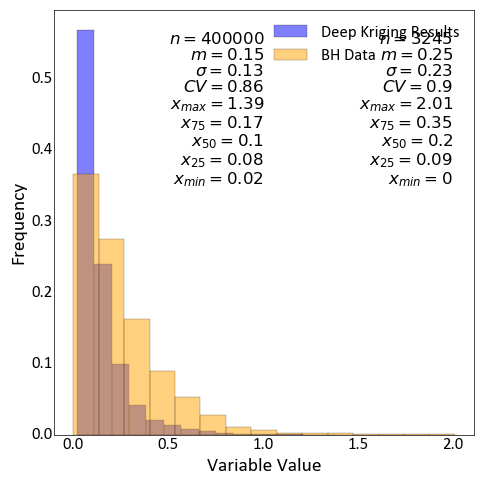

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the first histogram
gs.histogram_plot(
    deepkriging_results,
    var='0',
    ax=ax,
    color='blue',
    alpha=0.5,  
    stat_xy=(0.5,0.95), 
    label='Deep Kriging Results'
)

# Plot the second histogram
gs.histogram_plot(
    bhdata,
    var='Cu',
    ax=ax,
    color='orange',
    alpha=0.5,  
    label='BH Data'
)

# Customize labels, legend, and tick sizes
ax.set_xlabel("Variable Value", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.tick_params(labelsize=12)  #
plt.legend(fontsize=12)       

plt.tight_layout()
plt.show()


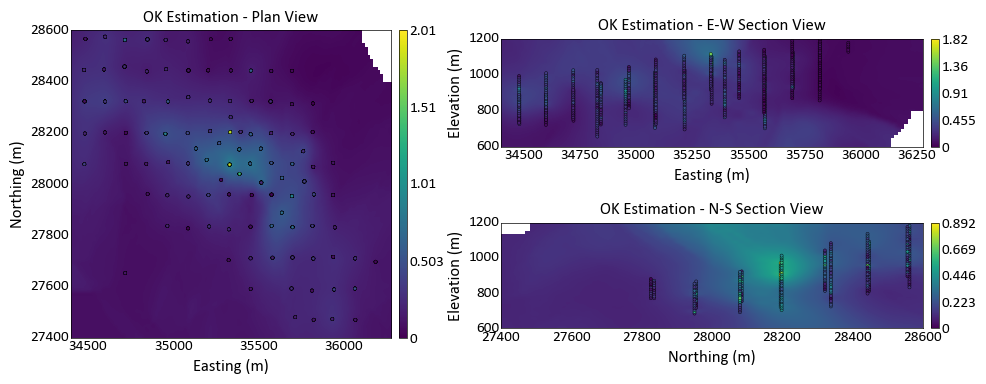

In [9]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig1 = plt.figure(figsize=(10, 4))
# Adjust the width_ratios to have three elements
gs2 = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Define the axes using the custom gridspec layout
ax0 = fig1.add_subplot(gs2[:, 0])
ax1 = fig1.add_subplot(gs2[0, 1])
ax2 = fig1.add_subplot(gs2[1, 1])


gs.slice_plot(ok_results, var = '0', pointdata = bhdata, pointvar = 'Cu', griddef=griddef, 
              pointkws={'edgecolors': 'k', 's':5}, title = 'OK Estimation - Plan View', ax = ax0,
              slice_number = 20, aspect = 1.5, slice_thickness=10)

gs.slice_plot(ok_results, var = '0', pointdata = bhdata, pointvar = 'Cu', griddef=griddef, 
              pointkws={'edgecolors': 'k', 's':5}, title = 'OK Estimation - E-W Section View', ax = ax1,
              slice_number = 60,  aspect = 0.8, orient = 'xz', slice_thickness=10)

gs.slice_plot(ok_results, var = '0', pointdata = bhdata, pointvar = 'Cu', griddef=griddef, 
              pointkws={'edgecolors': 'k', 's':5}, title = 'OK Estimation - N-S Section View', ax = ax2,
              slice_number = 40, aspect = 0.5, orient = 'yz', slice_thickness=10)

# Adjust the layout spacing
plt.tight_layout(h_pad = 3, w_pad = 1.5)
plt.show()


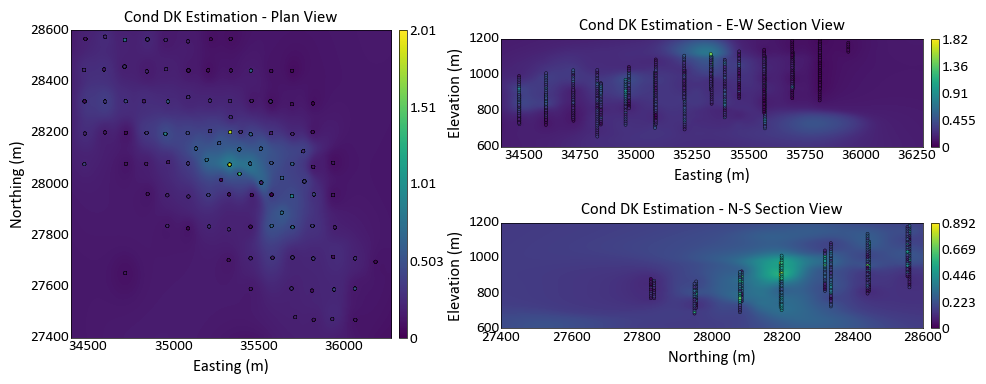

In [10]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig1 = plt.figure(figsize=(10, 4))
# Adjust the width_ratios to have three elements
gs2 = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Define the axes using the custom gridspec layout
ax0 = fig1.add_subplot(gs2[:, 0])
ax1 = fig1.add_subplot(gs2[0, 1])
ax2 = fig1.add_subplot(gs2[1, 1])


gs.slice_plot(Cond_DK_results, var = '0', pointdata = bhdata, pointvar = 'Cu', griddef=griddef, 
              pointkws={'edgecolors': 'k', 's':5}, title = 'Cond DK Estimation - Plan View', ax = ax0,
              slice_number = 20, aspect = 1.5, slice_thickness=10)

gs.slice_plot(Cond_DK_results, var = '0', pointdata = bhdata, pointvar = 'Cu', griddef=griddef, 
              pointkws={'edgecolors': 'k', 's':5}, title = 'Cond DK Estimation - E-W Section View', ax = ax1,
              slice_number = 60,  aspect = 0.8, orient = 'xz', slice_thickness=10)

gs.slice_plot(Cond_DK_results, var = '0', pointdata = bhdata, pointvar = 'Cu', griddef=griddef, 
              pointkws={'edgecolors': 'k', 's':5}, title = 'Cond DK Estimation - N-S Section View', ax = ax2,
              slice_number = 40, aspect = 0.5, orient = 'yz', slice_thickness=10)

# Adjust the layout spacing
plt.tight_layout(h_pad = 3, w_pad = 1.5)
plt.show()
